<a href="https://colab.research.google.com/github/AngelPn/Fake-News-Detector/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Authors
- 1115201800141 - Αγγελική Παναγοπούλου
- 1115201800142 - Θεοδώρα Παντελιού

# Fake News Detection
The objective of this task is to detect fake news in news articles. For the sake of simplicity, we say a news article is fake if it has a fake sentiment associated with it. So, the task is to classify fake news from other news.

Formally, given a training sample of news and labels, where label ‘1’ denotes non-fake news article and label ‘0’ denotes fake news article, your objective is to predict the labels on the given test dataset.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import Libraries

In [2]:
# For data manipulation and analysis
import pandas as pd
import numpy as np
import re
# For preprocessing
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
# For data vizualization 
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# For feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install --upgrade gensim
!pip install python-Levenshtein
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
# For feature-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
# To find the best parameters for SVM
from sklearn.model_selection import GridSearchCV
# Evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

     |████████████████████████████████| 23.9MB 141kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 51kB 3.2MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149803 sha256=dfffd47d785e0fe9cdeb34228acff3c2b0b1f191cbaa194093b1891cfd3cd4fd
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


# Load Datasets
Read the data from News_dataset directory using pandas read_csv method. News_dataset stores Fake.csv and True.csv files that keep fake and non-fake news respectively.

In [3]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/True.csv'

df_true = pd.read_csv(Location)
df_true.info()
df_true.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/Fake.csv'

df_fake = pd.read_csv(Location)
df_fake.info()
df_fake.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Preprocessing using WordNetLemmatizer
The **ntlk** is a suite of libraries and programs for symbolic and statistical natural language processing for English written in the Python programming language.

**Lemmatization** is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

We write a function which takes each sentence of a corpus as input and returns the lemmatized version of the word.



In [60]:
all_stopwords = gensim.parsing.preprocessing.STOPWORDS
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def stem_text(text):
  tokens = word_tokenize(text.lower())
  text = ' '.join([lemmatizer.lemmatize(token) for token in tokens if (token not in all_stopwords and token.isalpha() == True and len(token)>2)])

  return text

def preprocessing(df):
  df = df[~df.text.isna() & ~df.title.isna()] # remove NA values
  df['title'] = df['title'].apply(stem_text)
  df['text'] = df['text'].apply(stem_text)
  
  return df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [61]:
df_true_clean = preprocessing(df_true)
df_true_clean.info()
df_true_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 836.6+ KB


,title,text,subject,date
0,budget fight loom republican flip fiscal script,washington reuters head conservative republica...,politicsNews,"December 31, 2017"
1,military accept transgender recruit monday pen...,washington reuters transgender people allowed ...,politicsNews,"December 29, 2017"
2,senior republican senator mueller job,washington reuters special counsel investigati...,politicsNews,"December 31, 2017"
3,fbi russia probe helped australian diplomat nyt,washington reuters trump campaign adviser geor...,politicsNews,"December 30, 2017"
4,trump want postal service charge amazon shipment,reuters president donald trump called postal s...,politicsNews,"December 29, 2017"


In [62]:
df_fake_clean = preprocessing(df_fake)
df_fake_clean.info()
df_fake_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 917.2+ KB


,title,text,subject,date
0,donald trump sends embarrassing new year eve m...,donald trump couldn wish american happy new ye...,News,"December 31, 2017"
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,News,"December 31, 2017"
2,sheriff david clarke internet joke threatening...,friday revealed milwaukee sheriff david clarke...,News,"December 30, 2017"
3,trump obsessed obama coded website image,christmas day donald trump announced work foll...,News,"December 29, 2017"
4,pope francis called donald trump christmas speech,pope francis annual christmas day message rebu...,News,"December 25, 2017"


# Overview of data

## Titles visualization
Wordclouds to visualise the most common titles in fake and non-fake news.

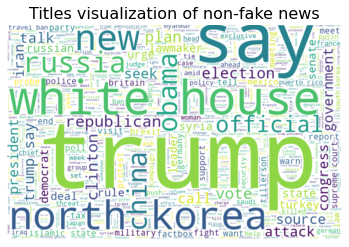

In [63]:
wordcloud = WordCloud(max_words=1000,width=840, height=540, background_color="white").generate(' '.join(df_true_clean['title'].tolist()))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Titles visualization of non-fake news', fontsize = 16)
plt.show()


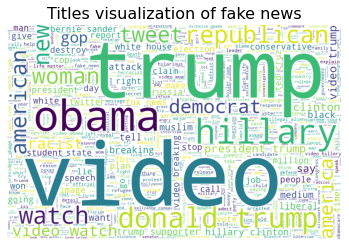

In [64]:
wordcloud = WordCloud(max_words=1000,width=840, height=540, background_color="white").generate(' '.join(df_fake_clean['title'].tolist()))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Titles visualization of fake news', fontsize = 16)
plt.show()


## Average number of characters
The function below gets as arguments a dataframe and a name of a column and returns the average number of characters for that column.

In [65]:
def average_chars_column(df, column):
  count = []
  for i, row in df.iterrows():
    count.append(len(row[column]))

  return sum(count)/len(count)


Graph that shows the average number of characters in title column for fake and non-fake news.

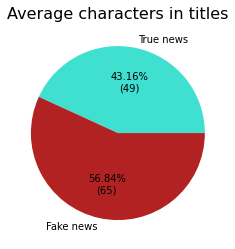

In [66]:
av_true = average_chars_column(df_true_clean, 'title')
av_fake = average_chars_column(df_fake_clean, 'title')

plt.pie(x = [av_true, av_fake], 
        labels = ['True news', 'Fake news'],
        colors = ['turquoise', 'firebrick'], 
        autopct = lambda p : '{:.2f}%\n({:.0f})'.format(p, (p/100)*(av_true+av_fake)))
plt.title('Average characters in titles', fontsize = 16)
plt.show()

Graph that shows the average number of characters in text column for fake and non-fake news.

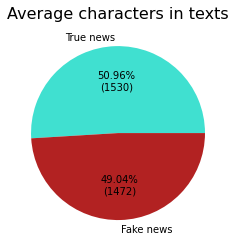

In [67]:
av_true = average_chars_column(df_true_clean, 'text')
av_fake = average_chars_column(df_fake_clean, 'text')

plt.pie(x=[av_true, av_fake], 
        labels=['True news', 'Fake news'], 
        colors=['turquoise', 'firebrick'], 
        autopct = lambda p : '{:.2f}%\n({:.0f})'.format(p, (p/100)*(av_true+av_fake)))
plt.title('Average characters in texts', fontsize = 16)
plt.show()

## Distribution of the number of words
We will check the distribution of length of the titles and texts, in terms of words, in both true and fake data and in both dirty and clean datasets.

### Dirty datasets
The distribution of number of words for the initial (dirty) datasets.

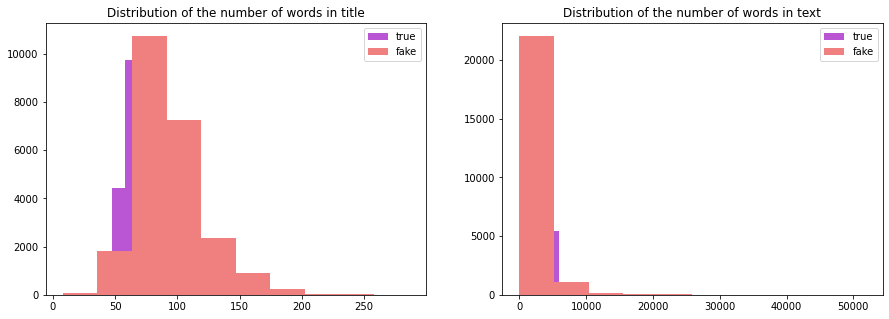

In [68]:
data=[]
data.append(df_true.title.str.len())
data.append(df_fake.title.str.len())
data.append(df_true.text.str.len())
data.append(df_fake.text.str.len())

titles = ['Distribution of the number of words in title','Distribution of the number of words in text'] 

fig,a = plt.subplots(1,2)
fig.set_size_inches(15, 5)
a = a.ravel()

idx_data = 0
idx_titles = 0

for ax in a:

    ax.hist(data[idx_data], label='true', color='mediumorchid')
    ax.hist(data[idx_data + 1], label='fake', color='lightcoral')
    ax.set_title(titles[idx_titles])
    ax.legend()

    idx_data = idx_data + 2
    idx_titles = idx_titles + 1

plt.show()

### Clean datasets
The distribution of number of words for the clean datasets removed from stopwords.

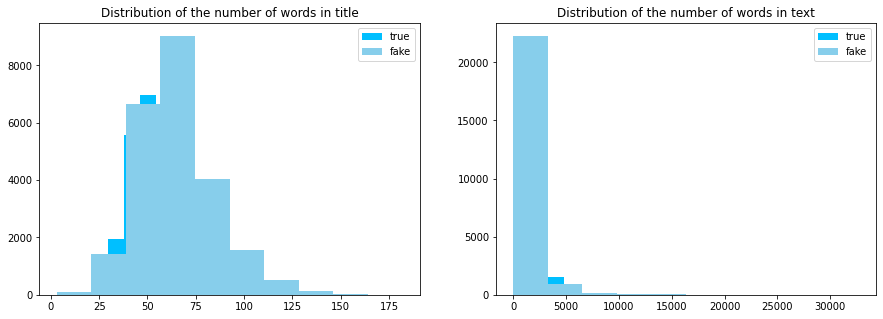

In [69]:
data=[]
data.append(df_true_clean.title.str.len())
data.append(df_fake_clean.title.str.len())
data.append(df_true_clean.text.str.len())
data.append(df_fake_clean.text.str.len())

titles = ['Distribution of the number of words in title','Distribution of the number of words in text'] 

fig,a = plt.subplots(1,2)
fig.set_size_inches(15, 5)
a = a.ravel()

idx_data = 0
idx_titles = 0

for ax in a:

    ax.hist(data[idx_data], label='true', color='deepskyblue')
    ax.hist(data[idx_data + 1], label='fake', color='skyblue')
    ax.set_title(titles[idx_titles])
    ax.legend()

    idx_data = idx_data + 2
    idx_titles = idx_titles + 1

plt.show()

## The most common bigrams
The function below returns the most k common bigrams given a dataframe's column.

In [70]:
def get_topk_bigrams(column, k = 20):
  "  returns bigram_names, bigram_counts "

  # Find bigrams through CountVectorizer
  bow_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', binary=True, max_features=k)
  bow_representation = bow_vectorizer.fit_transform(column)

  # To find the most common bigrams find the sum of each column
  bigram_counts = bow_representation.toarray().sum(axis=0)

  df_sorted = pd.DataFrame(zip(bigram_counts, bow_vectorizer.get_feature_names()), 
                           columns=['bigram_counts', 'bigram_names'])
  df_sorted.sort_values(by='bigram_counts', inplace=True)

  return df_sorted['bigram_names'], df_sorted['bigram_counts']


Most common bigrams in titles.

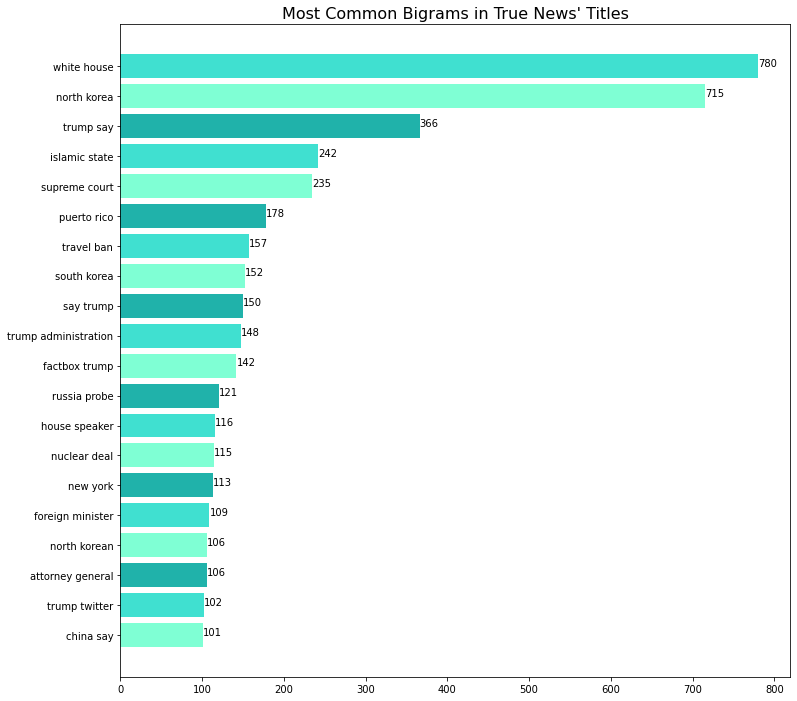

In [71]:
names, counts = get_topk_bigrams(df_true_clean['title'])

plt.figure(figsize=(12,12))
plt.barh(y=names, width=counts, color = ['aquamarine', 'turquoise', 'lightseagreen'])

for index, value in enumerate(counts):
    plt.text(value, index, str(value))

plt.title("Most Common Bigrams in True News' Titles", fontsize = 16)
plt.show()

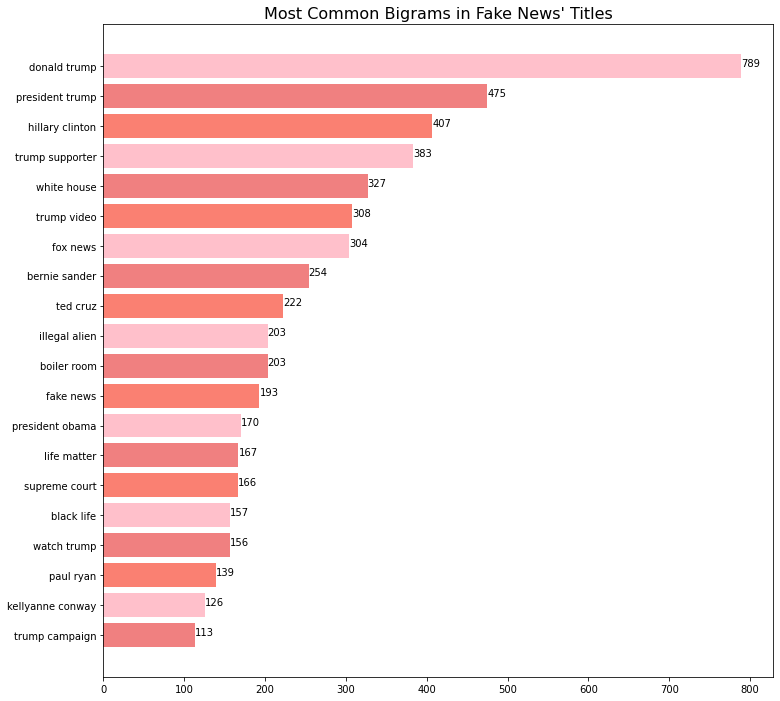

In [72]:
names, counts = get_topk_bigrams(df_fake_clean['title'])

plt.figure(figsize=(12,12))
plt.barh(y=names, width=counts, color = ['lightcoral', 'pink', 'salmon'])

for index, value in enumerate(counts):
    plt.text(value, index, str(value))
    
plt.title("Most Common Bigrams in Fake News' Titles", fontsize = 16)
plt.show()

Most common bigrams in texts.

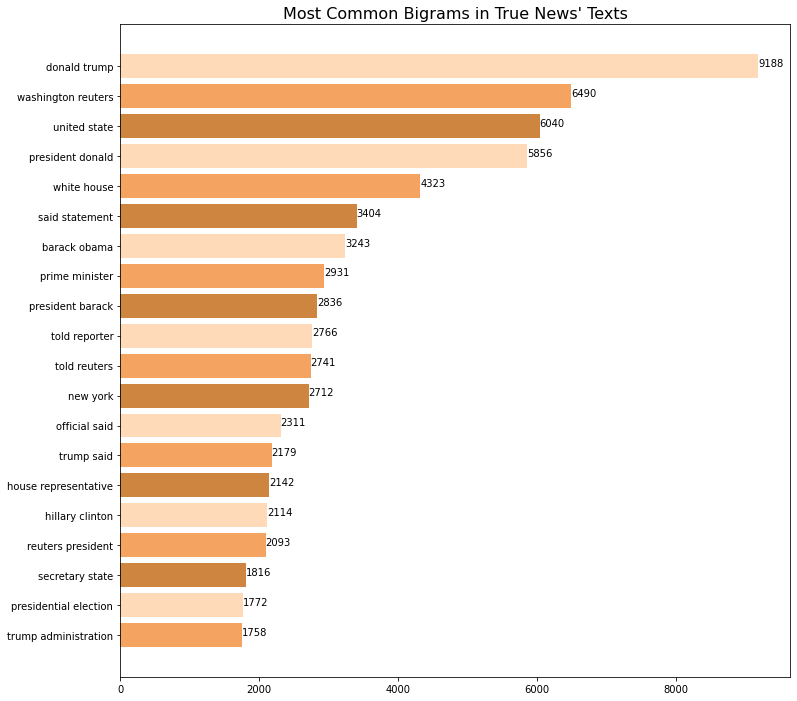

In [73]:
names, counts = get_topk_bigrams(df_true_clean['text'])

plt.figure(figsize=(12,12))
plt.barh(y=names, width=counts, color = ['sandybrown', 'peachpuff', 'peru'])

for index, value in enumerate(counts):
    plt.text(value, index, str(value))
    
plt.title("Most Common Bigrams in True News' Texts", fontsize = 16)
plt.show()

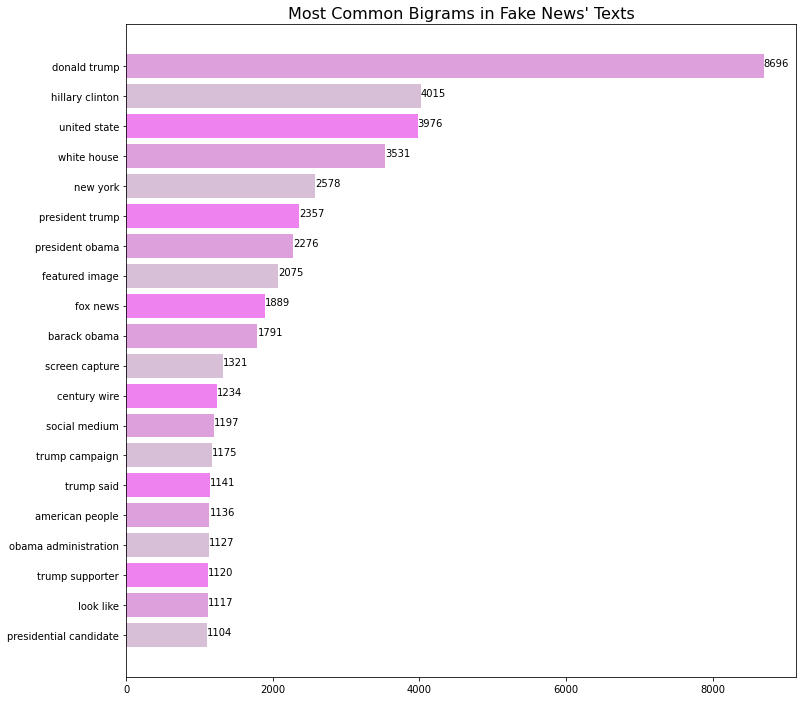

In [74]:
names, counts = get_topk_bigrams(df_fake_clean['text'])

plt.figure(figsize=(12,12))
plt.barh(y=names, width=counts, color = ['thistle', 'plum', 'violet'])
for index, value in enumerate(counts):
    plt.text(value, index, str(value))
    
plt.title("Most Common Bigrams in Fake News' Texts", fontsize = 16)
plt.show()

# Split into Train and Test Set


In [75]:
# Insert label with value '1' at dataframe of non-fake news
dftrue = df_true_clean.copy()
dftrue.insert(4, 'label', 1)

# Insert label with value '0' at dataframe of fake news
dffake = df_fake_clean.copy()
dffake.insert(4, 'label', 0)

# Combine dftrue and dffake
df_combi = pd.concat([dftrue, dffake], ignore_index=True, sort=False)

# Insert a column that merges title, text and subject
df_combi['merged'] = df_combi['title'] + ' ' + df_combi['text'] + ' ' + df_combi['subject']

# Split dataframe to train and test sets
dftrain, dftest, trainlabel, testlabel = train_test_split(df_combi.drop(columns = ['label']), 
                                                          df_combi['label'], 
                                                          random_state=42, 
                                                          test_size=0.3)
# Keep the train and test labels as numpy arrays
trainlabel = np.asarray(trainlabel)
testlabel = np.asarray(testlabel)

# Create the train and test csv files
Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/train.csv'
dftrain.to_csv(Location, index=False)

Location = r'/content/gdrive/MyDrive/ΤΕΔ/News_dataset/test.csv'
dftest.to_csv(Location, index=False)

In [76]:
dftrain.info()
dftest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31428 entries, 13970 to 15795
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    31428 non-null  object
 1   text     31428 non-null  object
 2   subject  31428 non-null  object
 3   date     31428 non-null  object
 4   merged   31428 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13470 entries, 22216 to 40968
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    13470 non-null  object
 1   text     13470 non-null  object
 2   subject  13470 non-null  object
 3   date     13470 non-null  object
 4   merged   13470 non-null  object
dtypes: object(5)
memory usage: 631.4+ KB


# Feature Extraction
To analyse a preprocessed data, it needs to be converted into features. We have to represent words in a numeric format that is understandable by the computers.

## Bag-of-Words
The bag of words approach is one of the simplest word embedding approaches. We will convert a collection of text documents to a matrix of token counts with CountVectorizer. We set 'min_df = 0.08' to build the vocabulary ignoring terms that have a document frequency strictly lower than the given threshold. This value is a cut-off, it means "ignore terms that appear in less than 8% of the documents".

In [78]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.08, stop_words='english')

bow_train = bow_vectorizer.fit_transform(dftrain.merged)
print(bow_train.shape)

bow_vectorizer.fit(dftrain.merged)
bow_test = bow_vectorizer.transform(dftest.merged)
print(bow_test.shape)

(31428, 270)
(13470, 270)


## TF-IDF
The TF-IDF scheme is a type of bag words approach where instead of adding zeros and ones in the embedding vector, you add floating numbers that contain more useful information compared to zeros and ones. We will convert a collection of raw documents to a matrix of TF-IDF features with TfidfVectorizer. We set 'min_df = 0.08' to build the vocabulary ignoring terms that have a document frequency strictly lower than the given threshold. This value is a cut-off, it means "ignore terms that appear in less than 8% of the documents".

In [79]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.08, stop_words='english')

tfidf_train = tfidf_vectorizer.fit_transform(dftrain.merged)
print(tfidf_train.shape)

tfidf_vectorizer.fit(dftrain.merged)
tfidf_test = tfidf_vectorizer.transform(dftest.merged)
print(tfidf_test.shape)

(31428, 270)
(13470, 270)


## Word2Vec
The advantages of using word embeddings over BoW/TF-IDF are:


*   Dimensionality reduction - significant reduction in the no. of features required to build a model.
*   It captures meanings of the words, semantic relationships and the different types of contexts they are used in.

We will work with gensim to generate new embeddings.

We are going to use the word vectors from word2vec model to create a vector representation for an entire news article (sentence) by taking the mean of all the word vectors present in the news article. The function below saves a vector for each article by taking the mean of the vectors of the words present in the article.


In [80]:
def w2v_representation(all_words, w2vmodel, vector_size = 200):

  # Initialize numpy array to have vector_size for each sentece in 'all_words' list
  w2v_representation = np.zeros(shape = (len(all_words), vector_size))

  for i, tokens in enumerate(all_words):
    vector = np.zeros(vector_size).reshape((1, vector_size))
    count = 0
    for j, word in enumerate(tokens):
        try:
          vector += w2vmodel.wv[word].reshape((1, vector_size))
          count += 1
        except KeyError: # handling the case where the token is not in vocabulary
          continue
    # Get the mean of vector
    if count != 0:
      vector /= count
    w2v_representation[i,:] = vector

  return w2v_representation

Create w2v representation for both train and test set.

In [81]:
train_tokens = dftrain.merged.str.split(' ') # tokenization of dftrain data
test_tokens = dftest.merged.str.split(' ') # tokenization of dftest data

w2v_train_model = Word2Vec(train_tokens, max_final_vocab=1000, vector_size=300, window=25)

w2v_train = w2v_representation(train_tokens, w2v_train_model, 300)
print(w2v_train.shape)

w2v_test = w2v_representation(test_tokens, w2v_train_model, 300)
print(w2v_test.shape)

(31428, 300)
(13470, 300)


# Feature-processing
Feature normalization is used in machine learning to make model training less sensitive to the scale of features.
The function below returns word representations normalized.

In [82]:
def Standard_Scaler(traindata, testdata):
  " takes 2 dense arrays one for train data and one for test data and returns standarized train and test data "
  scaler = StandardScaler().fit(traindata)
  traindata = scaler.transform(traindata)
  testdata = scaler.transform(testdata)
  return traindata, testdata


def MaxAbs_Scaler(traindata, testdata):
  transformer = MaxAbsScaler().fit(traindata)
  scaledtrain = transformer.transform(traindata)
  scaledtest = transformer.transform(testdata)
  return scaledtrain, scaledtest

In [83]:
bow_train, bow_test = MaxAbs_Scaler(bow_train, bow_test)
print(bow_train.mean(axis=0))

tfidf_train, tfidf_test = MaxAbs_Scaler(tfidf_train, tfidf_test)
print(tfidf_train.mean(axis=0))

w2v_train, w2v_test = Standard_Scaler(w2v_train, w2v_test)
print(w2v_train)

[[0.01601014 0.01459476 0.00828795 0.01576475 0.01149236 0.01722759
  0.02103008 0.01144973 0.01573438 0.00750845 0.01265553 0.01770184
  0.00725229 0.00765241 0.01220249 0.00921259 0.00842137 0.01143089
  0.01351502 0.01023769 0.00531373 0.01038296 0.03745977 0.01039494
  0.01309546 0.01092709 0.00432679 0.00704573 0.01358372 0.00547101
  0.01293357 0.00811909 0.02370498 0.00960973 0.01485482 0.0239682
  0.0193863  0.00693152 0.00837956 0.01239164 0.01493891 0.01399651
  0.01186505 0.01570483 0.00618529 0.01628091 0.01064338 0.00905471
  0.0221365  0.01512783 0.01341161 0.01252123 0.0166253  0.01000288
  0.02454022 0.00879321 0.02000605 0.01843301 0.01534062 0.00816682
  0.01320933 0.01870175 0.01866807 0.00371042 0.00714968 0.01007208
  0.01887762 0.01050726 0.00840138 0.01641494 0.0087788  0.01004316
  0.00711746 0.01166317 0.01245477 0.00951626 0.02197722 0.01282097
  0.01530937 0.01519725 0.01000951 0.00940987 0.01844456 0.0073413
  0.00437942 0.00508797 0.02531978 0.01962308 0.01

# Classifiers and Evaluation Metrics
We are going to evaluate and record the performance of each method in test data using the following evaluation metrics:

* **Accuracy score**: It is the fraction of predictions our model got right.

* **F1 score**: It is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

## Logistic Regression
Logistic Regression is a classification algorithm.  The training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross-entropy loss if the ‘multi_class’ option is set to ‘multinomial’. 

### Bag-of-Words Feautures
We will first try to fit the logistic regression model on the Bag-of-Words features.

In [84]:
lreg_model = LogisticRegression()
lreg_model.fit(bow_train, trainlabel) # training the model

accuracy = lreg_model.score(bow_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, lreg_model.predict(bow_test), average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  100.0 %
F1 score =  100.0 %


### TF-IDF Features

In [85]:
lreg_model = LogisticRegression()
lreg_model.fit(tfidf_train, trainlabel) # training the model

accuracy = lreg_model.score(tfidf_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, lreg_model.predict(tfidf_test), average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.62138084632517 %
F1 score =  99.62081357211538 %


### Word2Vec Features

In [86]:
lreg_model = LogisticRegression(max_iter=1000)
lreg_model.fit(w2v_train, trainlabel) # training the model

accuracy = lreg_model.score(w2v_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, lreg_model.predict(w2v_test), average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.33927245731255 %
F1 score =  99.33833507049145 %


## Naive Bayes
Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features .



### Bag-of-Words Features

In [90]:
nb_model = MultinomialNB()

nb_model.fit(bow_train, trainlabel) # training the model

accuracy = nb_model.score(bow_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = nb_model.predict(bow_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.52487008166295 %
F1 score =  99.5243201477256 %


### TF-IDF Features

In [91]:
nb_model.fit(tfidf_train, trainlabel) # training the model

accuracy = nb_model.score(tfidf_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = nb_model.predict(tfidf_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  95.91685226429102 %
F1 score =  95.91482589829992 %


### Word2Vec Features

In [89]:
nb_model = GaussianNB()
nb_model.fit(w2v_train, trainlabel) # training the model

accuracy = nb_model.score(w2v_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = nb_model.predict(w2v_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  92.19747587230883 %
F1 score =  92.19463452515807 %


## Support Vector Machines
Support-vector machines are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis. 

At first, we run GridSearchCV to find the best parameters for svm.SVC().

In [ ]:
parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

### Bag-of-Words Features

In [ ]:
svc = svm.SVC()
clf_search = GridSearchCV(svc, parameters)
clf_search.fit(bow_train, trainlabel)
clf_search.best_params_

{'C': 1, 'kernel': 'linear'}

Apply those parameters

In [25]:
clf = svm.SVC(C= 1, kernel='linear')
clf.fit(bow_train, trainlabel)

accuracy = clf.score(bow_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = clf.predict(bow_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  100.0 %
F1 score =  100.0 %


### TF-IDF Features

In [ ]:
svc = svm.SVC()
clf_search = GridSearchCV(svc, parameters)
clf_search.fit(tfidf_train, trainlabel)
clf_search.best_params_

{'C': 10, 'kernel': 'linear'}

Apply those parameters

In [92]:
clf = svm.SVC(C= 10, kernel='linear')
clf.fit(tfidf_train, trainlabel)

accuracy = clf.score(tfidf_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = clf.predict(tfidf_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.94803266518188 %
F1 score =  99.94795420418173 %


### Word2Vec Features

In [ ]:
svc = svm.SVC()
clf_search = GridSearchCV(svc, parameters)
clf_search.fit(w2v_train, trainlabel)
clf_search.best_params_

{'C': 10, 'kernel': 'linear'}

Apply those parameters

In [93]:
clf = svm.SVC(C= 10, kernel='linear')
clf.fit(w2v_train, trainlabel)

accuracy = clf.score(w2v_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = clf.predict(w2v_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.34669636228655 %
F1 score =  99.34575849096593 %


## Random Forests
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees.

### Bag-of-Words Features
We will train our RandomForest model on the Bag-of-Words features and check its performance on test set.

In [94]:
rf = RandomForestClassifier().fit(bow_train, trainlabel) 
prediction = rf.predict(bow_test)

accuracy = accuracy_score(testlabel, prediction)
print("Accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, prediction)
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.9554565701559 %
F1 score =  99.9536822603057 %


### TF-IDF Features

In [29]:
rf = RandomForestClassifier().fit(tfidf_train, trainlabel) 
prediction = rf.predict(tfidf_test)

accuracy = accuracy_score(testlabel, prediction)
print("accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, prediction)
print("F1 score = ", f1 * 100, "%")

accuracy =  99.93318485523385 %
F1 score =  99.93053947673071 %


### Word2Vec Features

In [38]:
rf = RandomForestClassifier().fit(w2v_train, trainlabel) 
prediction = rf.predict(w2v_test)

accuracy = accuracy_score(testlabel, prediction)
print("Αccuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, prediction)
print("F1 score = ", f1 * 100, "%")

Αccuracy =  97.79510022271715 %
F1 score =  97.70567786790268 %


# Conclusions
Ιnitially, we cleaned our text data using nltk, then we learned about 3 different types of feature-set that we can extract from any text data, and finally we used these feature-sets to build models for sentiment analysis. Below is a summary table showing Accuracy and F1 scores for different models and feature-sets.

|                         |   BoW   |   TF-IDF   |   Word2Vec  |
| :---------------------- | :-----: | :--------: | ----------: |
| **Logistic Regression** | 100     | 99.6213    |   99.3392   |
|                         | 100     | 99.6208    |   99.3383   |
| **Naive Bayes**         | 99.5248 | 95.9168    |   92.1974   |
|                         | 99.5243 | 95.9148    |   92.1946   |
| **SVM**                 | 100     | 99.9480    |   99.3466   |
|                         | 100     | 99.9479    |   99.3457   |
| **Random Forests**      | 99.9554 | 99.9331    |   97.7951   |
|                         | 99.9536 | 99.9305    |   97.7056   |

Bag-of-Words features turned out to be most useful. Whereas Logistic Regression and SVM with Bag-of-Words features were the best models for this problem.
It was expected that Word2Vec features would have the best evaluation scores, due to the power of word embeddings in dealing with NLP problems. However, the combination of preprocessing, data standardization and the BoW vocabulary ignoring terms that appear in less than 8% of the documents, gave these good results that we tried to achieve through our many tests on preprocessing methods, standardization methods and parameters value changes. You can find the process of exploring the best preprocessing method and parameters in this [Spreadsheet](https://docs.google.com/spreadsheets/d/1Y0N_sVZeVngbB8Skt6Jy0ZEt9w9kfZeZWvnVROCH818/edit?usp=sharing). Using these specific values on parameters to functions for feature extraction, we achieved not only better scores, but better time performance. For example, runtime of Random Forests classifier was approximately 15 mins and now is a few seconds. We estimate that using pretrained word-embeddings as Word2Vec features would give even better results.

# Beat the Benchmark

# Preprocessing using SnowBallStemmer

**Stemming** is a kind of normalization for words. It is a technique where a set of words in a sentence are converted into a sequence to shorten its lookup. The nltk provides many inbuilt stemmers and we will use Snowball Stemmer for that purpose.

We write a function which takes each sentence of a corpus as input and returns the stemmed version of the word.

In [95]:
nltk.download('punkt')
stemmer = SnowballStemmer(language='english')
all_stopwords = gensim.parsing.preprocessing.STOPWORDS

def stem_text(text):
  tokens = word_tokenize(text.lower())
  text = ' '.join([stemmer.stem(token) for token in tokens if (token not in all_stopwords and token.isalpha() == True and len(token)>2)])

  return text

def preprocessing2(df):
  df = df[~df.text.isna() & ~df.title.isna()] # remove NA values
  df['title'] = df['title'].apply(stem_text)
  df['text'] = df['text'].apply(stem_text)
  
  return df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [96]:
df_true_clean2 = preprocessing2(df_true)
df_fake_clean2 = preprocessing2(df_fake)

In [97]:
df_true_clean2.info()
df_true_clean2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 836.6+ KB


,title,text,subject,date
0,budget fight loom republican flip fiscal script,washington reuter head conserv republican fact...,politicsNews,"December 31, 2017"
1,militari accept transgend recruit monday pentagon,washington reuter transgend peopl allow time e...,politicsNews,"December 29, 2017"
2,senior republican senat mueller job,washington reuter special counsel investig lin...,politicsNews,"December 31, 2017"
3,fbi russia probe help australian diplomat nyt,washington reuter trump campaign advis georg p...,politicsNews,"December 30, 2017"
4,trump want postal servic charg amazon shipment,reuter presid donald trump call postal servic ...,politicsNews,"December 29, 2017"


In [98]:
df_fake_clean2.info()
df_fake_clean2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 917.2+ KB


,title,text,subject,date
0,donald trump send embarrass new year eve messa...,donald trump couldn wish american happi new ye...,News,"December 31, 2017"
1,drunk brag trump staffer start russian collus ...,hous intellig committe chairman devin nune go ...,News,"December 31, 2017"
2,sheriff david clark internet joke threaten pok...,friday reveal milwauke sheriff david clark con...,News,"December 30, 2017"
3,trump obsess obama code websit imag,christma day donald trump announc work follow ...,News,"December 29, 2017"
4,pope franci call donald trump christma speech,pope franci annual christma day messag rebuk d...,News,"December 25, 2017"


## Split into Train and Test set

In [99]:
# Insert label with value '1' at dataframe of non-fake news
dftrue = df_true_clean2.copy()
dftrue.insert(4, 'label', 1)

# Insert label with value '0' at dataframe of fake news
dffake = df_fake_clean2.copy()
dffake.insert(4, 'label', 0)

# Combine dftrue and dffake
df_combi = pd.concat([dftrue, dffake], ignore_index=True, sort=False)

# Insert a column that merges title, text and subject
df_combi['merged'] = df_combi[df_combi.columns[0:3]].apply(
    lambda x: ' '.join(x.dropna().astype(str)),
    axis=1
)

# Split dataframe to train and test sets
dftrain, dftest, trainlabel, testlabel = train_test_split(df_combi.drop(columns = ['label']), 
                                                          df_combi['label'], 
                                                          random_state=42, 
                                                          test_size=0.3)
# Keep the train and test labels as numpy arrays
trainlabel = np.asarray(trainlabel)
testlabel = np.asarray(testlabel)

dftrain.info()
dftest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31428 entries, 13970 to 15795
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    31428 non-null  object
 1   text     31428 non-null  object
 2   subject  31428 non-null  object
 3   date     31428 non-null  object
 4   merged   31428 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13470 entries, 22216 to 40968
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    13470 non-null  object
 1   text     13470 non-null  object
 2   subject  13470 non-null  object
 3   date     13470 non-null  object
 4   merged   13470 non-null  object
dtypes: object(5)
memory usage: 631.4+ KB


## Feature Extraction


### Bag-of-Words

In [100]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.08, stop_words='english')

bow_train = bow_vectorizer.fit_transform(dftrain.merged)
print(bow_train.shape)

bow_vectorizer.fit(dftrain.merged)
bow_test = bow_vectorizer.transform(dftest.merged)
print(bow_test.shape)

(31428, 339)
(13470, 339)


### TF-IDF

In [101]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=0.08, stop_words='english')

tfidf_train = tfidf_vectorizer.fit_transform(dftrain.merged)
print(tfidf_train.shape)

tfidf_vectorizer.fit(dftrain.merged)
tfidf_test = tfidf_vectorizer.transform(dftest.merged)
print(tfidf_test.shape)

(31428, 339)
(13470, 339)


### Word2Vec

In [102]:
train_tokens = dftrain.merged.str.split(' ') # tokenization of dftrain data
test_tokens = dftest.merged.str.split(' ') # tokenization of dftest data

w2v_train_model = Word2Vec(train_tokens, max_final_vocab=1000, vector_size=300, window=25)

w2v_train = w2v_representation(train_tokens, w2v_train_model, 300)
print(w2v_train.shape)

w2v_test = w2v_representation(test_tokens, w2v_train_model, 300)
print(w2v_test.shape)

(31428, 300)
(13470, 300)


## Feature-processing

In [103]:
bow_train, bow_test = MaxAbs_Scaler(bow_train, bow_test)
print(bow_train.mean(axis=0))

tfidf_train, tfidf_test = MaxAbs_Scaler(tfidf_train, tfidf_test)
print(tfidf_train.mean(axis=0))

w2v_train, w2v_test = Standard_Scaler(w2v_train, w2v_test)
print(w2v_train)

[[0.01602075 0.01597469 0.00515994 0.0106805  0.01062914 0.01580814
  0.01101838 0.01140703 0.01763764 0.01145643 0.01573438 0.01149236
  0.00711595 0.01005738 0.01481618 0.00750845 0.01266008 0.01332411
  0.01552756 0.01979688 0.00810459 0.01143161 0.01067321 0.01221204
  0.00921259 0.00846167 0.00313188 0.01761536 0.01355081 0.01030663
  0.00534111 0.00520616 0.00615163 0.0110947  0.01039494 0.01383382
  0.01101062 0.01046383 0.00433405 0.00551677 0.00812472 0.00925219
  0.01358372 0.01295478 0.01078222 0.01827457 0.00961019 0.01674621
  0.02696518 0.02121154 0.01553665 0.00693152 0.00837956 0.01239517
  0.01734653 0.01401249 0.0055669  0.01399651 0.01206266 0.01822419
  0.02414089 0.00710527 0.01628091 0.01064338 0.00914411 0.00912517
  0.01912307 0.02068674 0.00733506 0.02214024 0.01668894 0.01737304
  0.01388662 0.00719316 0.01475896 0.01365378 0.01024328 0.02454022
  0.01390833 0.01098543 0.00886808 0.01227959 0.02000704 0.01843301
  0.01534062 0.00791726 0.01320933 0.02174757 0.

## Logistic Regression

### Bag-of-Words Features

In [104]:
lreg_model = LogisticRegression()
lreg_model.fit(bow_train, trainlabel) # training the model

accuracy = lreg_model.score(bow_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, lreg_model.predict(bow_test), average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  100.0 %
F1 score =  100.0 %


### TF-IDF Features

In [106]:
lreg_model = LogisticRegression()
lreg_model.fit(tfidf_train, trainlabel) # training the model

accuracy = lreg_model.score(tfidf_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, lreg_model.predict(tfidf_test), average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.64365256124722 %
F1 score =  99.6431124804409 %


### Word2Vec Features

In [107]:
lreg_model = LogisticRegression(max_iter=1000)
lreg_model.fit(w2v_train, trainlabel) # training the model

accuracy = lreg_model.score(w2v_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, lreg_model.predict(w2v_test), average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.51744617668894 %
F1 score =  99.5167723432467 %


## Naive Bayes

### Bag-of-Words Features

In [108]:
nb_model = MultinomialNB()

nb_model.fit(bow_train, trainlabel) # training the model

accuracy = nb_model.score(bow_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = nb_model.predict(bow_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.65107646622123 %
F1 score =  99.65064203334956 %


### TF-IDF Features

In [109]:
nb_model.fit(tfidf_train, trainlabel) # training the model

accuracy = nb_model.score(tfidf_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = nb_model.predict(tfidf_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  96.2731997030438 %
F1 score =  96.27047624334061 %


### Word2Vec Features

In [110]:
nb_model = GaussianNB()
nb_model.fit(w2v_train, trainlabel) # training the model

accuracy = nb_model.score(w2v_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = nb_model.predict(w2v_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  91.88567186340015 %
F1 score =  91.8828533789555 %


## Support Vector Machine

### Bag-of-Words Features

In [111]:
clf = svm.SVC(C= 1, kernel='linear')
clf.fit(bow_train, trainlabel)

accuracy = clf.score(bow_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = clf.predict(bow_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  100.0 %
F1 score =  100.0 %


### TF-IDF Features

In [112]:
clf = svm.SVC(C= 10, kernel='linear')
clf.fit(tfidf_train, trainlabel)

accuracy = clf.score(tfidf_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = clf.predict(tfidf_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.94060876020787 %
F1 score =  99.94051805725175 %


### Word2Vec Features

In [113]:
clf = svm.SVC(C= 10, kernel='linear')
clf.fit(w2v_train, trainlabel)

accuracy = clf.score(w2v_test, testlabel)
print("Accuracy = ", accuracy * 100, "%")

prediction = clf.predict(w2v_test)
f1 = f1_score(testlabel, prediction, average='macro')
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.52487008166295 %
F1 score =  99.52414997392121 %


## Random Forests

### Bag-of-Words Features

In [114]:
rf = RandomForestClassifier().fit(bow_train, trainlabel) 
prediction = rf.predict(bow_test)

accuracy = accuracy_score(testlabel, prediction)
print("Accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, prediction)
print("F1 score = ", f1 * 100, "%")

Accuracy =  99.9554565701559 %
F1 score =  99.95366795366796 %


### TF-IDF Features

In [115]:
rf = RandomForestClassifier().fit(tfidf_train, trainlabel) 
prediction = rf.predict(tfidf_test)

accuracy = accuracy_score(testlabel, prediction)
print("accuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, prediction)
print("F1 score = ", f1 * 100, "%")

accuracy =  99.97030438010394 %
F1 score =  99.9691167387276 %


### Word2Vec Features

In [116]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(w2v_train, trainlabel) 
prediction = rf.predict(w2v_test)

accuracy = accuracy_score(testlabel, prediction)
print("Αccuracy = ", accuracy * 100, "%")

f1 = f1_score(testlabel, prediction)
print("F1 score = ", f1 * 100, "%")

Αccuracy =  97.8173719376392 %
F1 score =  97.7262180974478 %


## Conclusions
We followed the same process as above, that is: We cleaned our text data using nltk with SnowBallStemmer, then we learned about 3 different types of feature-set that we can extract from any text data, and finally we used these feature-sets to build models for sentiment analysis. Below is a summary table showing Accuracy and F1 scores for different models and feature-sets. In bolds are the scores we got with preprocessing using SnowBallStemmer and besides every score, is the score we got with preprocesing using WordNetLemmatizer.

|                         |   BoW                 |   TF-IDF              |   Word2Vec           |
| :---------------------- | :-------------------: | :-------------------: | -----------------: |
| **Logistic Regression** | 100 - **100**         | 99.6213 - **99.6436** | 99.3392 - **99.5174** |
|                         | 100 - **100**         | 99.6208 - **99.6431** | 99.3383 - **99.5167** |
| **Naive Bayes**         | 99.5248 - **99.6510** | 95.9168 - **96.2731** | 92.1974 - **91.8856** |
|                         | 99.5243 - **99.6507** | 95.9148 - **96.2704** | 92.1946 - **91.8828** |
| **SVM**                 | 100 - **100**         | 99.9480 - **99.9406** | 99.3466 - **99.5248** |
|                         | 100 - **100**         | 99.9479 - **99.9405** | 99.3457 - **99.5241** |
| **Random Forests**      | 99.9554 - **99.9554** | 99.9331 - **99.9703**  | 97.7951 - **97.8173** |
|                         | 99.9536 - **99.9536** | 99.9305 - **99.9691**  | 97.7056 - **97.7262** |

As we can see, in most of the cases, the scores are better and in the cases that this is not true, the differences are very small. We estimate that this happens because the cleaned dataset contains more or less the same words. The used preprocessing methods and parameters came from the process of exploring the best ones that you can find in this [Spreadsheet](https://docs.google.com/spreadsheets/d/1Y0N_sVZeVngbB8Skt6Jy0ZEt9w9kfZeZWvnVROCH818/edit?usp=sharing).